# Create WecOptTool Model for the Marson WEC concept

In [26]:
import logging
import numpy as np
import capytaine as cpt
import pygmsh
import gmsh
import vtk
import matplotlib.pyplot as plt
import os
import xarray as xr
from capytaine.io.meshio import load_from_meshio

logging.basicConfig(level=logging.INFO,format="%(levelnames)s:\t%(message)s")

#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.

-0.09461939908732306
FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_3259"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={"Surge": ..., "Sway": ..., "Heave": ..., "Roll": ..., "Pitch": ..., "Yaw": ...}, center_of_mass=[-1.  0.  0.], name="rect 0")
-0.09461939908732306
FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_3279"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={"Surge": ..., "Sway": ..., "Heave": ..., "Roll": ..., "Pitch": ..., "Yaw": ...}, center_of_mass=[-3.  0.  0.], name="rect 1")


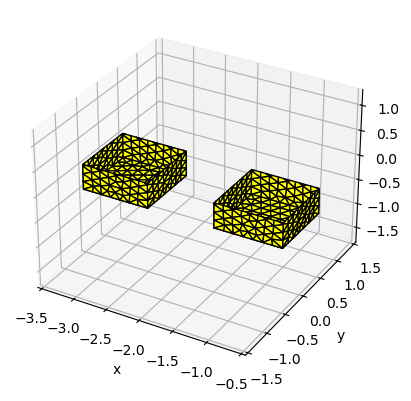

In [27]:
numBodies = 2
bodyDist = 2 # distanc between each body's cg
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] # assumes bodies are connected to stationary PTO at x=0
mesh_size_factor = 0.16 # works well for this size 
bodHeight = [1.1, 1.1]
bodDraft = [0.5, 0.5]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [1, 1]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = [] 

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]/2],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]/2],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]/2],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]/2]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, bodHeight[nBod]-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-bodHeight[nBod]])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(10) # add lid to reduce irregular frequency peaks
        print(lid_pos)
        lid_pos = -.05
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name=f'rect {nBod}', center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_all_rigid_body_dofs()
        print(rect[nBod])

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

all_bodies.show_matplotlib()


In [28]:
folder_path = 'hs'

myBodies = bodList

for i in range(2):
    myBodies[i].keep_immersed_part()
    myBodies[i].add_all_rigid_body_dofs()

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i, body in enumerate(myBodies):

    cg = body.center_of_mass
    body_hs = body.compute_hydrostatics(rho=1023.0)
    vo = body_hs['disp_volume']
    cb = body_hs['center_of_buoyancy']
    khs = body_hs['hydrostatic_stiffness']

    # Write hydrostatic stiffness to KH.dat file
    khs_full = np.zeros((6,6))
    khs_full[2:5, 2:5] += khs[2:5, 2:5]
    tmp = folder_path + '/KH' + '_' + str(i) +'.dat'
    np.savetxt(tmp, khs_full)

    # Write the other hydrostatics data to Hydrostatics.dat file
    tmp = folder_path + '/Hydrostatics' + '_' + str(i) + '.dat'
    f = open(tmp,'w')
    for j in [0,1,2]:
        line =  f'XF = {cb[j]:7.3f} - XG = {cg[j]:7.3f} \n'
        f.write(line)
    line = f'Displacement = {vo:E}'
    f.write(line)
    f.close()


In [29]:
ncFName = 'attenuator.nc'

path,tmp = os.path.split(os.getcwd() + os.path.sep + ncFName)
path += os.path.sep

# combine all bodies to account for B2B interaction

#both_fb = cpt.FloatingBody.join_bodies(rect1,rect2)

freqs = np.linspace(1/8, 10*1/8, 10)

# set frequencies
wCapy =  2*np.pi*freqs                  # wave frequencies
headings = np.linspace(0,np.pi/2,1)  
depth = np.infty
density = 1025.0

# call Capytaine solver
print(f'\n-------------------------------\n'
    f'Calling Capytaine BEM solver...\n'
    f'-------------------------------\n'
    f'mesh = {all_bodies.name}\n'
    f'w range = {wCapy[0]:.3f} - {wCapy[-1]:.3f} rad/s\n'
    f'dw = {(wCapy[1]-wCapy[0]):.3f} rad/s\n'
    f'no of headings = {len(headings)}\n'
    f'no of radiation & diffraction problems = {len(wCapy)*(len(headings) + len(all_bodies.dofs))}\n'
    f'-------------------------------\n')

problems = xr.Dataset(coords={
    'omega': wCapy,
    'wave_direction': headings,
    'radiating_dof': list(all_bodies.dofs),
    'water_depth': [depth],
    'rho': [density],
    })

solver = cpt.BEMSolver()
capyData = solver.fill_dataset(problems, [all_bodies], hydrostatics=False)

# save to .nc file
cpt.io.xarray.separate_complex_values(capyData).to_netcdf(ncFName, encoding={'radiating_dof': {'dtype': 'U'}, 'influenced_dof': {'dtype': 'U'}})
print('\nCapytaine call complete. Data saved to \n' + ncFName +'\n\n')


-------------------------------
Calling Capytaine BEM solver...
-------------------------------
mesh = rect 0+rect 1
w range = 0.785 - 7.854 rad/s
dw = 0.785 rad/s
no of headings = 1
no of radiation & diffraction problems = 130
-------------------------------



Output()


Capytaine call complete. Data saved to 
attenuator.nc


